# Подключаем необходимые библиотеки

In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from pandas import datetime
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

# Считываем наши данные

In [2]:
data = pd.read_csv('products.csv', sep='|', error_bad_lines=False)

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,1,5,7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Рассмотрим три отдельные категории: DRY EYE, ALERGY, VIT B и выделим из датасета три поднабора

In [3]:
dry_eye = data[data['PRODUCT_CATEGORY_LABEL']=='DRY EYE']

In [4]:
alergy = data[data['PRODUCT_CATEGORY_LABEL']=='ALERGY']

In [5]:
vit_b = data[data['PRODUCT_CATEGORY_LABEL']=='VIT B']

# Рассмотрим подробнее первый поднабор

In [6]:
dry_eye.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48186 entries, 1673 to 19461110
Data columns (total 11 columns):
WEEK                      48186 non-null object
PLN                       48186 non-null object
PLN_LABEL                 48186 non-null object
PRODUCT_CATEGORY          48186 non-null object
PRODUCT_CATEGORY_LABEL    48186 non-null object
OPSTUDY                   48186 non-null object
OPSTUDY_LABEL             48186 non-null object
ACTUAL                    48186 non-null object
BU                        47915 non-null object
SEG                       48186 non-null object
PROMO                     40513 non-null object
dtypes: object(11)
memory usage: 4.4+ MB


In [7]:
dry_eye.head()

,WEEK,PLN,PLN_LABEL,PRODUCT_CATEGORY,PRODUCT_CATEGORY_LABEL,OPSTUDY,OPSTUDY_LABEL,ACTUAL,BU,SEG,PROMO
1673,1160529,40000415307,REFRESH OPTIVE ADVANCED 10ML,186-002,DRY EYE,186,EYE/EAR,150,Health/Wellness,A,N
1674,1160529,40000415307,REFRESH OPTIVE ADVANCED 10ML,186-002,DRY EYE,186,EYE/EAR,1113,Health/Wellness,C1,N
1675,1160529,40000415307,REFRESH OPTIVE ADVANCED 10ML,186-002,DRY EYE,186,EYE/EAR,295,Health/Wellness,B,N
1676,1160529,40000415307,REFRESH OPTIVE ADVANCED 10ML,186-002,DRY EYE,186,EYE/EAR,15,Health/Wellness,NoSegment-C,N
2474,1160529,40000684179,THERA TEARS LUB EYE DROPS 15ML,186-002,DRY EYE,186,EYE/EAR,153,Health/Wellness,A,N


## Удаляем ненужные столбцы (признак BU можем удалить т.к. все наши данные итак принадлежат BU == 'Health/Wellness', аналогичная логика рассуждений и для других удаляемых признаков, ведь все они имеют одинаковые значения)

In [8]:
dry_eye.drop(['BU', 'PRODUCT_CATEGORY_LABEL', 'PRODUCT_CATEGORY', 'OPSTUDY', 'OPSTUDY_LABEL'], axis=1, inplace=True)

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Преобразуем признаки в необходимые типы

In [9]:
dry_eye['WEEK'] = dry_eye['WEEK'].apply(lambda x: str(x))

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
dry_eye['PLN'] = dry_eye['PLN'].apply(lambda x: str(x))

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
dry_eye['PLN_LABEL'] = dry_eye['PLN_LABEL'].apply(lambda x: str(x))

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
dry_eye['ACTUAL'] = dry_eye['ACTUAL'].apply(lambda x: float(x))

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
dry_eye['SEG'] = dry_eye['SEG'].apply(lambda x: str(x))

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
dry_eye['PROMO'] = dry_eye['PROMO'].apply(lambda x: str(x))

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Преобразуем признак WEEK в datetime и создадим три новых колонки: YEAR, MONTH, DAY для того, чтобы, например, посмотреть как менялись продажи товара каждый месяц в разные года

### Колонка WEEK имеет неподходящий вид для перевода в тип datetime, поэтому напишем функцию, чтобы немного преобразовать данные в этой колонке

In [15]:
def date_divide(x):
    x=x[1:]
    x='20' + x
    x=x[:4] + '-' + x[4:]
    x=x[:7] + '-' + x[7:]
    return x

In [16]:
dry_eye['WEEK'] = dry_eye['WEEK'].apply(lambda x: date_divide(x))

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Переводим данные в дату 

In [17]:
dry_eye['WEEK'] = pd.to_datetime(dry_eye['WEEK'])

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Создаем новые три колонки с годом, месяцем и днем (неделей) 

In [18]:
dry_eye['YEAR'] = [d.year for d in dry_eye['WEEK']]
dry_eye['MONTH'] = [d.month for d in dry_eye['WEEK']]
dry_eye['DAY'] = [d.day for d in dry_eye['WEEK']]

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

## Заменим значения признака SEG на числовые 

### Создаем словарь, дге каждому строковому значению признака соответствует число 

In [19]:
seg_dic = {'A':0, 'NoSegmen-A':1, 'B':2, 'NoSegment-B':3, 'C1':4, 'C2':5, 'C3':6, 'C4':7, 'NoSegment-C':8, 'NoBuisnessUnit':9}

In [20]:
dry_eye['SEG'] = dry_eye['SEG'].replace(seg_dic)

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Если в датасете имеются отрицательные значения продаж, то заменим их на нулевые

In [21]:
def replace_negative(x):
    if x<0:
        return 0
    else:
        return x

In [22]:
dry_eye['ACTUAL'] = dry_eye['ACTUAL'].apply(lambda x: replace_negative(x))

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Заменим значения PROMO 'Y', 'N' на 1, 0

In [23]:
promo_dic = {'Y':1, 'N':0}

In [24]:
dry_eye['PROMO'] = dry_eye['PROMO'].replace(promo_dic)

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Взглянем на получившейся набор после преобразований 

In [25]:
dry_eye.head()

,WEEK,PLN,PLN_LABEL,ACTUAL,SEG,PROMO,YEAR,MONTH,DAY
1673,2016-05-29,40000415307,REFRESH OPTIVE ADVANCED 10ML,150.0,0,0,2016,5,29
1674,2016-05-29,40000415307,REFRESH OPTIVE ADVANCED 10ML,1113.0,4,0,2016,5,29
1675,2016-05-29,40000415307,REFRESH OPTIVE ADVANCED 10ML,295.0,2,0,2016,5,29
1676,2016-05-29,40000415307,REFRESH OPTIVE ADVANCED 10ML,15.0,8,0,2016,5,29
2474,2016-05-29,40000684179,THERA TEARS LUB EYE DROPS 15ML,153.0,0,0,2016,5,29


## Выведем гистограму продаж

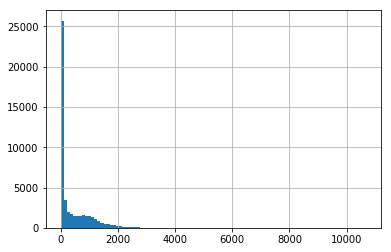

In [26]:
dry_eye['ACTUAL'].hist(bins=100);

### Видно из гистограммы, что продажи не распределены по нормальному закону 

## График количества продаж в каждый месяц по годам

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


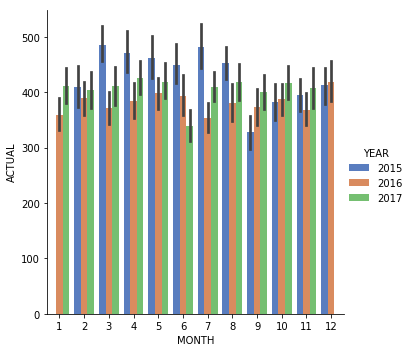

In [27]:
sns.catplot(x='MONTH', y='ACTUAL', hue='YEAR', data=dry_eye, kind='bar', palette='muted');

### Из графика продаж в принципе видно, что у данной категории нет никаких сезонных компонент

## Рассмотрим подробнее и попытаемся спрогнозировать продажи самого популярного продукта данной категории

In [28]:
dry_eye['PLN_LABEL'].value_counts()

BLINK GEL TEAR LUB EYE DROPS.34OZ    942
BLINK TEARS LUBRICATING DRPS .5OZ    935
BLINK TEARS LUBRICATING DROPS 1OZ    898
WALG ARTIFICIAL TEAR LBRCNT .5OZ     876
B&L SOOTHE LUB EYE DRPS .02OZ 28S    849
VISINE TEARS FOR DRY EYES    .5OZ    838
VISINE TEARS L/LST RLF DRYEYE.5OZ    826
SOOTHE HYDRATION DRY EYE DROP.5OZ    823
WALG LUB E DRP SNGL USE .01OZ 30S    819
SYSTANE ULT HIGH PERFORMANC .33OZ    797
WALG SODIUM CHLR OPTH ONT 5%.13OZ    785
SYSTANE LUB EYE DRP          .5OZ    782
B&L SOOTHE XP                15ML    779
SYSTANE BLNC LBRCNT EYE DROP.33OZ    776
SYSTANE PM LUBE EYE OINTMENT.12OZ    763
SYSTANE ULTRA            .33OZ 2S    753
WALG LUB E DRP SNGL USE .01OZ 70S    751
SYSTANE BALANCE EYE DROP .33OZ 2S    750
SIMILASAN E/DROP D/EYE 30014.33OZ    747
SIMILASAN CMPLT E RLF DRPS .33OZ     741
WALGREENS MURO 128 DROPS    .500Z    736
WALG ULT LUB EYEDRP VIAL .01OZ25S    726
SYSTANE LUB EYE DRP          30ML    721
SYSTANE ULTRA POCKET PACK.14OZ 2S    719
SYSTANE GEL DROP

In [29]:
first_item = dry_eye[dry_eye['PLN_LABEL']=='BLINK GEL TEAR LUB EYE DROPS.34OZ']

## Можем удалить колонки 'PLN' и 'PLN_LABEL', ведь мы уже определились с конкретным товаром 

In [30]:
first_item.drop(['PLN_LABEL', 'PLN'], axis=1, inplace=True)

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


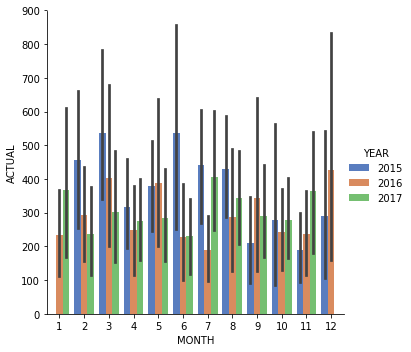

In [220]:
sns.catplot(x='MONTH', y='ACTUAL', hue='YEAR', data=first_item, kind='bar', palette='muted');

In [31]:
first_item['WEEK'].value_counts()

2017-07-09    14
2017-05-28     8
2016-09-11     8
2016-10-09     8
2017-05-14     8
2017-03-12     8
2016-07-24     8
2016-11-06     8
2015-12-06     8
2016-04-17     8
2015-09-27     8
2017-02-12     8
2016-06-26     8
2015-11-08     8
2015-10-25     8
2016-06-12     8
2017-01-29     8
2017-06-04     8
2015-11-22     8
2016-07-10     8
2017-02-26     8
2017-04-30     8
2016-01-24     8
2017-03-26     8
2015-11-01     8
2016-11-13     8
2015-09-06     8
2016-04-24     8
2017-07-30     8
2015-10-04     8
              ..
2015-07-26     4
2015-08-23     4
2016-05-08     4
2015-03-01     4
2015-03-29     4
2015-04-26     4
2017-11-05     4
2015-05-24     4
2015-06-21     4
2016-02-07     4
2015-04-05     4
2017-08-20     4
2016-03-27     4
2017-01-01     4
2015-02-15     4
2016-05-22     4
2017-01-08     4
2015-03-15     4
2015-04-12     4
2015-05-10     4
2017-11-19     4
2015-06-07     4
2015-07-05     4
2016-02-21     4
2015-08-02     4
2016-03-20     4
2015-08-30     4
2015-02-08    

### Как видно выше недели повторяютя, сделаем так, чтобы на каждую конкретную неделю была только одна запись, для этого сложим все значения продаж для каждых повторяющихся недель. Также если хотя бы в одной из повторяющихся недель товар был на акции, то считаем, что и в "суммированной" недели он тоже будет на акции

In [32]:
weeks = np.unique(first_item['WEEK'].values)
sums = []
promos = []
indexes = first_item.index

In [33]:
for w in weeks:
    s = 0
    promo = 0
    for i in indexes:
        if first_item.at[i, 'WEEK']==w:
            s=s+first_item.at[i, 'ACTUAL']
            if first_item.at[i, 'PROMO']==1:
                promo = 1
    sums.append(s)
    promos.append(promo)

In [34]:
first_item1 = pd.DataFrame({'WEEK': weeks, 'ACTUAL': sums, 'PROMO': promos})

# Загрузим сразу данные на будующий год, для которого необходимо сделать прогноз 

In [55]:
future = pd.read_csv('future.csv', sep='|', error_bad_lines=False)

In [56]:
future.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7199527 entries, 0 to 7199526
Data columns (total 4 columns):
1171126        int64
40000980460    int64
B              object
N              object
dtypes: int64(2), object(2)
memory usage: 219.7+ MB


In [57]:
future.head()

,1171126,40000980460,B,N
0,1171126,40000980460,NoSegment-C,N
1,1171126,40000980460,C4,N
2,1171126,40000223091,NoSegment-C,N
3,1171126,40000223091,C4,N
4,1171126,40000755059,A,N


## Переименуем столбцы

In [60]:
future.rename(index=str, columns={'1171126':'WEEK', '40000980460':'PLN', 'B':'SEG', 'N':'PROMO'}, inplace=True)

## Приведем данные в необходимые нам типы 

In [62]:
future['WEEK'] = future['WEEK'].apply(lambda x: str(x))

In [63]:
future['PLN'] = future['PLN'].apply(lambda x: str(x))

In [64]:
future['SEG'] = future['SEG'].apply(lambda x: str(x))

In [65]:
future['PROMO'] = future['PROMO'].apply(lambda x: str(x))

## Переведем WEEK в datetime 

In [66]:
future['WEEK'] = future['WEEK'].apply(lambda x: date_divide(x))

In [67]:
future['WEEK'] = pd.to_datetime(future['WEEK'])

## Заменим данные SEG на числовые 

In [68]:
future['SEG'] = future['SEG'].replace(seg_dic)

## Сделаем замену и для PROMO 

In [69]:
future['PROMO'] = future['PROMO'].replace(promo_dic)

In [70]:
future.head()

,WEEK,PLN,SEG,PROMO
0,2017-11-26,40000980460,8,0
1,2017-11-26,40000980460,7,0
2,2017-11-26,40000223091,8,0
3,2017-11-26,40000223091,7,0
4,2017-11-26,40000755059,0,0


## Возьмем отдуда необходимый нам продукт 

In [72]:
fut_first_prod = future[future['PLN']=='40000529197']

In [73]:
fut_first_prod.drop(['SEG', 'PLN'], axis=1, inplace=True)

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [74]:
fut_first_prod.head()

,WEEK,PROMO
91117,2017-11-26,0
91118,2017-11-26,0
91119,2017-11-26,0
91120,2017-11-26,0
144951,2017-12-03,1


### Как и в основном нашем наборе недели повторяются

In [75]:
fut_first_prod['PROMO'].value_counts()

0    173
1    163
Name: PROMO, dtype: int64

In [76]:
weeks = np.unique(fut_first_prod['WEEK'].values)
promos = []
indexes = fut_first_prod.index

In [78]:
for w in weeks:
    promo = 0
    for i in indexes:
        if fut_first_prod.at[i, 'WEEK']==w:
            if fut_first_prod.at[i, 'PROMO']==1:
                promo = 1
    promos.append(promo)

In [79]:
fut_first_prod1 = pd.DataFrame({'WEEK': weeks, 'PROMO': promos})

In [80]:
fut_first_prod1.head()

,WEEK,PROMO
0,2017-11-26,0
1,2017-12-03,1
2,2017-12-10,1
3,2017-12-17,1
4,2017-12-24,1


## Для составления прогноза воспользуемся моделью временных рядов ARIMA

### Ограничимся только двумя признаками: WEEK и ACTUAL 

In [35]:
first = first_item1[['WEEK', 'ACTUAL']].copy()

### Проиндексируем набор по неделям 

In [36]:
first.set_index('WEEK', inplace=True)

### Построим график продаж 

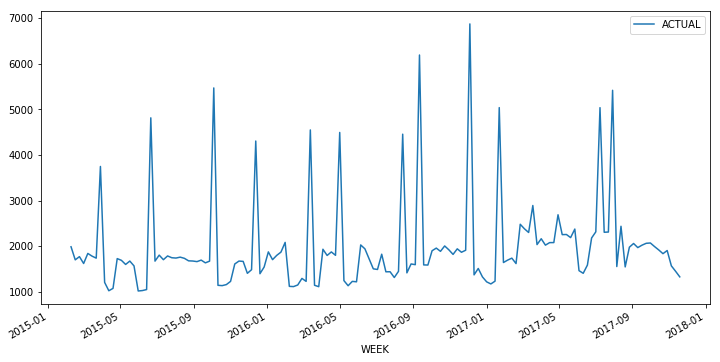

In [37]:
first.plot(figsize=(12, 6));

### Как видно из гистограммы ниже, выборка не принадлежит нормальному распределению 

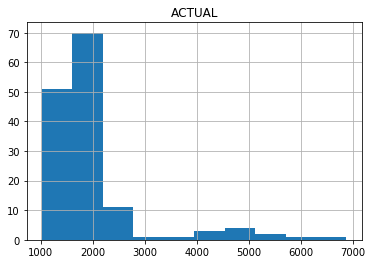

In [38]:
first.hist();

### Коэффициент варриации небольшой 

In [39]:
first.std()/first.mean()

ACTUAL    0.514481
dtype: float64

### Тест на нормальность подтверждает то, что выборка не принадлежит нормальному закону распределения 

In [40]:
sp.stats.normaltest(first)

NormaltestResult(statistic=array([100.59806112]), pvalue=array([1.43023889e-22]))

### Для проверки стационарности ряда проведем тест Дикки-Фуллера 

In [41]:
sm.tsa.adfuller(first['ACTUAL'])

(-12.630353423663642,
 1.5095860676700053e-23,
 0,
 144,
 {'1%': -3.476597917537401,
  '5%': -2.8818291230495543,
  '10%': -2.5775887982253085},
 2180.4555049303044)

### Ряд оказался стационарным, что позволяет нам применить данную модель

### Построим график автокорреляционной и найдем порядок компоненты AR - p

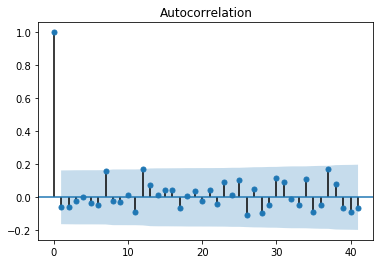

In [81]:
sm.graphics.tsa.plot_acf(first.values.squeeze(), lags=41);

### Из графика видно. что только одна компонента сильно выделяется (отличается от нуля), следовательно p=1 

### Строим график частично автокорреляционной функции и находим порядок компоненты MA - q

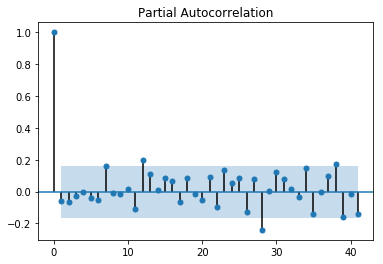

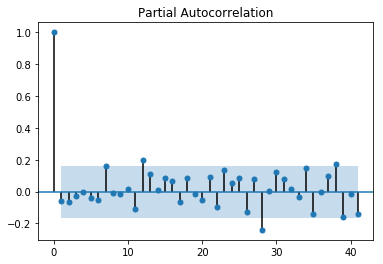

In [82]:
sm.graphics.tsa.plot_pacf(first, lags=41)

### Из графика видно. что только одна компонента сильно выделяется (отличается от нуля), следовательно q=1

In [83]:
p = 1
q = 1
d = 0

### Строим модель на тренировочной выборке (возьмем в качестве train значения до 2017 года) 

In [45]:
train = first[:'2017-01-01']

In [85]:
arima_model = sm.tsa.ARIMA(train, order=(1, 1, 1)).fit(full_output=True, disp=0)

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### Параметры нашей модели 

In [47]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.ACTUAL   No. Observations:                   98
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -823.217
Method:                       css-mle   S.D. of innovations           1050.150
Date:                Fri, 18 Jan 2019   AIC                           1654.433
Time:                        10:02:46   BIC                           1664.773
Sample:                             1   HQIC                          1658.616
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.2257      3.343      1.264      0.209      -2.327      10.778
ar.L1.D.ACTUAL    -0.1082      0.101     -1.075      0.285      -0.305       0.089
ma.L1.D.ACTUAL    -1.0000      0.028    -36.002      0.000      -1.054      -0.946
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -9.2412           +0.0000j            9.2412            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

### Делаем прогноз на 2017 год 

In [48]:
prediction = arima_model.predict(start=99, end=140, typ='levels')

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


### Находим  коэффициент детерминации, чтобы понять насколько точно было предсказание

In [49]:
r2_score(first[99:141], prediction)

-0.00906904886341442

### Рисуем график нашего предсказания 

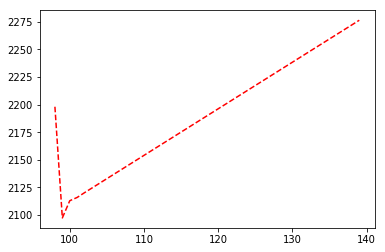

In [86]:
#first.plot(figsize=(12,6))
prediction.plot(style='r--')

### Как видно из графика и из коеффициента детерминации, модель предсказывает достаточно плохо 

## Проделаем теперь тоже самое, но для прогноза на новый год 

### Обучим нашу модель на все выборе  

In [88]:
arima_model = sm.tsa.ARIMA(first, order=(1, 1, 1)).fit(full_output=True, disp=0)

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### Параметры нашей модели 

In [89]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.ACTUAL   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1201.698
Method:                       css-mle   S.D. of innovations           1000.591
Date:                Fri, 18 Jan 2019   AIC                           2411.397
Time:                        10:47:52   BIC                           2423.276
Sample:                             1   HQIC                          2416.224
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.8040      1.839      2.068      0.040       0.199       7.409
ar.L1.D.ACTUAL    -0.0812      0.083     -0.976      0.331      -0.244       0.082
ma.L1.D.ACTUAL    -1.0000      0.019    -52.339      0.000      -1.037      -0.963
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -12.3143           +0.0000j           12.3143            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

## Сделаем прогноз 

In [90]:
new_pred = arima_model.predict(start=144, end=192, typ='levels')

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [91]:
new_pred

143    2321.932049
144    2336.033075
145    2258.611861
146    2269.011833
147    2272.280147
148    2276.127599
149    2279.928022
150    2283.732263
151    2287.536194
152    2291.340151
153    2295.144105
154    2298.948060
155    2302.752014
156    2306.555969
157    2310.359923
158    2314.163878
159    2317.967833
160    2321.771787
161    2325.575742
162    2329.379696
163    2333.183651
164    2336.987605
165    2340.791560
166    2344.595514
167    2348.399469
168    2352.203424
169    2356.007378
170    2359.811333
171    2363.615287
172    2367.419242
173    2371.223196
174    2375.027151
175    2378.831105
176    2382.635060
177    2386.439015
178    2390.242969
179    2394.046924
180    2397.850878
181    2401.654833
182    2405.458787
183    2409.262742
184    2413.066696
185    2416.870651
186    2420.674606
187    2424.478560
188    2428.282515
189    2432.086469
190    2435.890424
191    2439.694378
dtype: float64

### Нарисуем график 

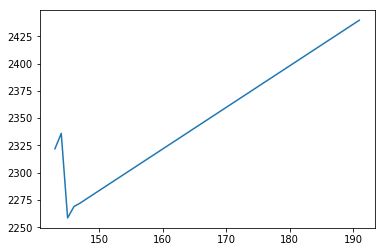

In [96]:
new_pred.plot()

## Прогноз при помощи Vector Autoregression 

### Как мы выяснили ранее из графика продаж в разные месяца, данные не имеют каких-либо трендовых или сезоных компонент, поэтому данный метод применим

In [51]:
var_set = first_item1.copy()

In [52]:
var_set.set_index('WEEK', inplace=True)

In [93]:
#var_train = var_set[:'2017-01-01']

In [ ]:
var_model = VAR(var_train)

In [ ]:
results = var_model.fit(2)

In [ ]:
results.plot();

In [ ]:
results.plot_forecast(45)

## Прогноз при помощи Simple Exponential Smoothing

###  Метод простого экспоненциального сглаживания (SES) моделирует следующий временной шаг как экспоненциально взвешенную линейную функцию наблюдений на предыдущих временных шагах.

### Как и в случае с Vector Autoregression метод подходит для данных, в которых отсутствуют какие-либо сезонные тренды

### Разделим данные на тестовую и тренировучную выборки 

In [151]:
ses_train = first_item1.drop('PROMO', axis=1).set_index('WEEK')[:100]

In [152]:
ses_test = first_item1.drop('PROMO', axis=1).set_index('WEEK')[100:]

### Обучаем нашу модель 

In [147]:
ses_model = SimpleExpSmoothing(ses_train)

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [148]:
ses_model_fit = ses_model.fit()

### Строим прогноз 

In [226]:
fit1 = ExponentialSmoothing(ses_train, seasonal_periods=21, trend='add', seasonal='add').fit(use_boxcox=True)

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


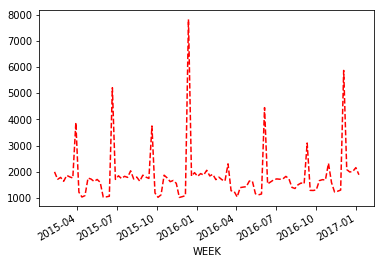

In [174]:
fit1.fittedvalues.plot(style='--', color='red')

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


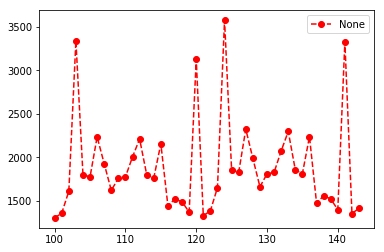

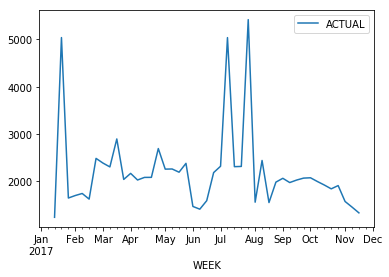

In [227]:
fit1.forecast(44).plot(style='--', marker='o', color='red', legend=True)
ses_test.plot()

## Нарисуем график продаж на протяжении 3-х лет

In [243]:
first_item_act = first_item1[['WEEK', 'ACTUAL', 'PROMO']].copy()

In [244]:
first_item_act.set_index('WEEK', inplace=True)

In [270]:
scaler = MinMaxScaler()

In [271]:
scaler.fit(first_item_act)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [272]:
first_item_act = scaler.transform(first_item_act)

In [283]:
first_item_act = pd.DataFrame({'WEEK': first_item1['WEEK'].values, 'ACTUAL': first_item_act[:,0], 'PROMO': first_item1['PROMO'].values})

In [284]:
first_item_act.set_index('WEEK', inplace=True)

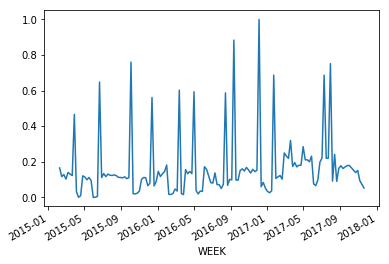

In [285]:
first_item_act['ACTUAL'].plot();

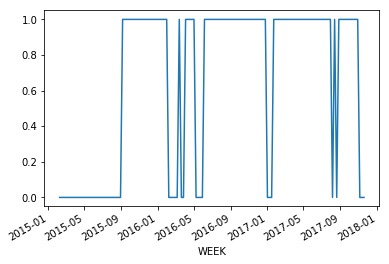

In [286]:
first_item_act['PROMO'].plot();

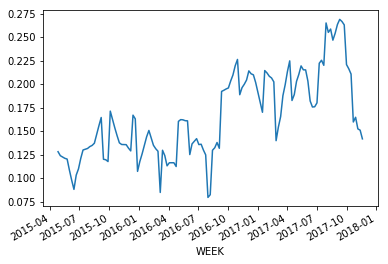

In [287]:
first_item_act['ACTUAL'].rolling(12).mean().plot();

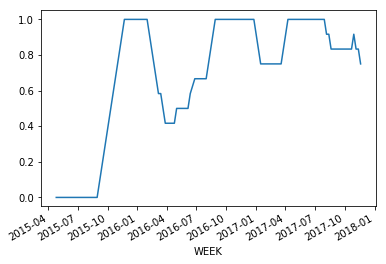

In [288]:
first_item_act['PROMO'].rolling(12).mean().plot();

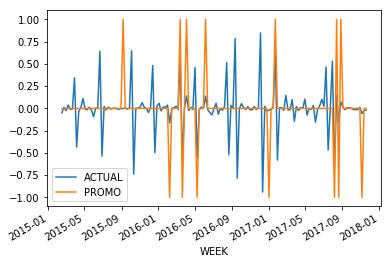

In [289]:
first_item_act.diff().plot();

In [290]:
first_item_act.diff().corr()

,ACTUAL,PROMO
ACTUAL,1.000000,0.344041
PROMO,0.344041,1.000000


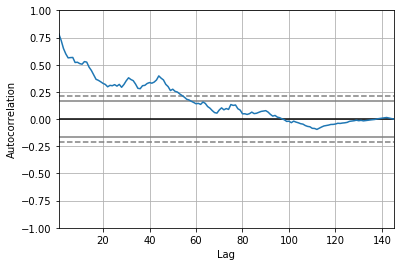

In [291]:
pd.plotting.autocorrelation_plot(first_item_act);